# Исследование тарифных планов мобильного оператора

Оператор мобильной связи предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Нужно понять, какой тариф приносит больше денег.

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей мобильного оператора: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

Бизнес-задача -  Нужно проанализировать поведение клиентов и сделать вывод — какой тариф приносит больше денег.

Задача DS - По выборке определить параметры генеральной совокупности.

#### Пояснение к датасету:

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана
    
Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_users = pd.read_csv('/datasets/users.csv')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [4]:
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [5]:
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


### Вывод

У нас 4 таблицы, пропущенных данных нет, кроме churn_date, но это объяснимо. В датах не правильные типы данных и нужно выполить округление вверх по условию задачи. 

## Шаг 2. Подготовьте данные

In [6]:
# Приведём данные к нужным типам. Исправим даты.

df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'])
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

# По условию округление вверх в длительности и Мб.

df_calls['duration'] = np.around(df_calls['duration']).astype(int)
df_internet['mb_used'] = np.around(df_internet['mb_used']).astype(int)

In [7]:
# Исправим ошибки в данных. В df_internet удалим лишний столбец.

df_internet.drop(df_internet.columns[0], axis='columns', inplace=True)

In [8]:
# Удалим нулевые значения. Если бы мы считали, например, нагрузку на сеть, тогда это было бы важно, но мы считаем выручку.

df_calls = df_calls[df_calls['duration'] > 0]
df_internet = df_internet[df_internet['mb_used'] > 0]

In [9]:
# Количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя.

df_calls['call_month'] = df_calls['call_date'].dt.month

df = (df_calls.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['sum', 'count'])
                .reset_index())
df.columns = ['user_id', 'month', 'duration_sum', 'duration_count']

In [10]:
# Количество отправленных сообщений по месяцам для каждого пользователя.

df_messages['message_month'] = df_messages['message_date'].dt.month

df_messages_pvt = (df_messages.pivot_table(index=['user_id', 'message_month'], values='message_date', aggfunc='count')
                   .reset_index())
df_messages_pvt.columns = ['user_id', 'month', 'message_count']

# Добавляем в большой датасет.

df = df.merge(df_messages_pvt, how='outer', left_on=['user_id', 'month'], right_on=['user_id', 'month'])
df

,user_id,month,duration_sum,duration_count,message_count
0,1000,5,149.0,16.0,22.0
1,1000,6,159.0,27.0,60.0
2,1000,7,319.0,39.0,75.0
3,1000,8,391.0,42.0,81.0
4,1000,9,439.0,45.0,57.0
...,...,...,...,...,...
3207,1489,8,NaN,NaN,17.0
3208,1489,9,NaN,NaN,32.0
3209,1489,10,NaN,NaN,21.0
3210,1489,11,NaN,NaN,20.0


In [11]:
# Объем израсходованного интернет-трафика по месяцам для каждого пользователя.

df_internet['session_month'] = df_internet['session_date'].dt.month

df_internet_pvt = (df_internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc=['sum', 'count'])
                   .reset_index())
df_internet_pvt.columns = ['user_id', 'month', 'mb_used_sum', 'mb_used_count']

# Добавляем в большой датасет. 

df = df.merge(df_internet_pvt, how='outer', left_on=['user_id', 'month'], right_on=['user_id', 'month'])

# Добавляем нужное из df_users. Столбцы передвинем для удобства.

df = df.merge(df_users[['user_id', 'city', 'tariff']], left_on='user_id', right_on='user_id')
df = df[['user_id', 'month', 'city', 'tariff', 'duration_sum', 'duration_count', 'message_count', 'mb_used_sum', 'mb_used_count']]
df

,user_id,month,city,tariff,duration_sum,duration_count,message_count,mb_used_sum,mb_used_count
0,1000,5,Краснодар,ultra,149.0,16.0,22.0,2253.0,4.0
1,1000,6,Краснодар,ultra,159.0,27.0,60.0,23232.0,44.0
2,1000,7,Краснодар,ultra,319.0,39.0,75.0,14004.0,28.0
3,1000,8,Краснодар,ultra,391.0,42.0,81.0,14054.0,27.0
4,1000,9,Краснодар,ultra,439.0,45.0,57.0,14569.0,25.0
...,...,...,...,...,...,...,...,...,...
3209,1489,8,Санкт-Петербург,smart,NaN,NaN,17.0,11051.0,28.0
3210,1489,9,Санкт-Петербург,smart,NaN,NaN,32.0,17205.0,49.0
3211,1489,10,Санкт-Петербург,smart,NaN,NaN,21.0,19558.0,52.0
3212,1489,11,Санкт-Петербург,smart,NaN,NaN,20.0,17489.0,45.0


In [12]:
# Если данные пропущены, то результативного использования не было. Можно заполнить нулями. Приведем к типу int.

df.fillna(0, inplace=True)

df['message_count'] = df['message_count'].astype(int)

In [13]:
# Добавим данные по тарифу и уберем дублирующиеся.

df = df.merge(df_tariffs, left_on='tariff', right_on='tariff_name')

df.drop(df.columns[16], axis='columns', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
user_id                  3214 non-null int64
month                    3214 non-null int64
city                     3214 non-null object
tariff                   3214 non-null object
duration_sum             3214 non-null float64
duration_count           3214 non-null float64
message_count            3214 non-null int64
mb_used_sum              3214 non-null float64
mb_used_count            3214 non-null float64
messages_included        3214 non-null int64
mb_per_month_included    3214 non-null int64
minutes_included         3214 non-null int64
rub_monthly_fee          3214 non-null int64
rub_per_gb               3214 non-null int64
rub_per_message          3214 non-null int64
rub_per_minute           3214 non-null int64
dtypes: float64(4), int64(10), object(2)
memory usage: 426.9+ KB


##### Чтобы посчитать для каждого пользователя помесячную выручку, для удобства, разобьём большой датасет на три, по услуге. Найдём выручку по каждой услуге, а потом сложим и получим общую.

In [14]:
# Звонки

df_duration = df[['user_id', 'month', 'duration_sum', 'minutes_included', 'rub_per_minute']]

# Считаем превышение

df_duration.loc[df_duration['duration_sum'] > df_duration['minutes_included'], 'duration_excees'] = \
df_duration.loc[df_duration['duration_sum'] > df_duration['minutes_included'], 'duration_sum'] - \
df_duration.loc[df_duration['duration_sum'] > df_duration['minutes_included'], 'minutes_included']

df_duration.loc[df_duration['duration_sum'] <= df_duration['minutes_included'], 'duration_excees'] = 0

# Вычисляем выручку с звонков, которые превысили тариф

df_duration['call_earnings'] = df_duration['rub_per_minute'] * df_duration['duration_excees']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [15]:
# Сообщения

df_msg = df[['user_id', 'month', 'message_count', 'messages_included', 'rub_per_message']]

# Считаем превышение

df_msg.loc[df_msg['message_count'] > df_msg['messages_included'], 'msg_excees'] = \
df_msg.loc[df_msg['message_count'] > df_msg['messages_included'], 'message_count'] - \
df_msg.loc[df_msg['message_count'] > df_msg['messages_included'], 'messages_included']

df_msg.loc[df_msg['message_count'] <= df_msg['messages_included'], 'msg_excees'] = 0

# Вычисляем выручку с сообщений, которые превысили тариф

df_msg['msg_earnings'] = df_msg['rub_per_message'] * df_msg['msg_excees']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [16]:
# Интернет

df_int = df[['user_id', 'month', 'mb_used_sum', 'mb_per_month_included', 'rub_per_gb']]

# Высчитаем превышение в гигабайтах

df_int['gb_used_sum'] = np.around(df_int['mb_used_sum'] / 1024).astype(int)
df_int['gb_per_month_included'] = df_int['mb_per_month_included'] / 1024

# Считаем превышение

df_int.loc[df_int['gb_used_sum'] > df_int['gb_per_month_included'], 'gb_excees'] = \
df_int.loc[df_int['gb_used_sum'] > df_int['gb_per_month_included'], 'gb_used_sum'] - \
df_int.loc[df_int['gb_used_sum'] > df_int['gb_per_month_included'], 'gb_per_month_included']

df_int.loc[df_int['gb_used_sum'] <= df_int['gb_per_month_included'], 'gb_excees'] = 0

# Вычисляем выручку с гигабайт, которые превысили тариф

df_int['int_earnings'] = df_int['rub_per_gb'] * df_int['gb_excees']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/panda

In [17]:
# Собираем датасет с выручкой.

df_earnings = df[['user_id', 'month', 'city', 'tariff', 'rub_monthly_fee']]

df_earnings = (df_earnings
               .merge(df_duration[['user_id', 'month', 'call_earnings']], 
                      left_on=['user_id', 'month'], 
                      right_on=['user_id', 'month']))

df_earnings = (df_earnings
               .merge(df_msg[['user_id', 'month', 'msg_earnings']], 
                      left_on=['user_id', 'month'], 
                      right_on=['user_id', 'month']))
               
df_earnings = (df_earnings
               .merge(df_int[['user_id', 'month', 'int_earnings']], 
                      left_on=['user_id', 'month'], 
                      right_on=['user_id', 'month']))

In [18]:
# Добавляем итоговую выручку по каждому клиенту в месяц с абонентской платой.

df_earnings.loc[:, 'earnings'] = df_earnings['rub_monthly_fee'] + df_earnings['call_earnings'] + \
df_earnings['msg_earnings'] + df_earnings['int_earnings']

df_earnings.sort_values('earnings', ascending=False)

,user_id,month,city,tariff,rub_monthly_fee,call_earnings,msg_earnings,int_earnings,earnings
3157,1486,12,Нижний Новгород,smart,550,1368.0,99.0,4600.0,6617.0
2177,1261,12,Казань,smart,550,1557.0,0.0,3400.0,5507.0
1183,1042,12,Хабаровск,smart,550,546.0,75.0,4200.0,5371.0
3156,1486,11,Нижний Новгород,smart,550,669.0,138.0,4000.0,5357.0
2298,1286,12,Москва,smart,550,576.0,54.0,3800.0,4980.0
...,...,...,...,...,...,...,...,...,...
2058,1229,10,Москва,smart,550,0.0,0.0,0.0,550.0
2659,1378,1,Иркутск,smart,550,0.0,0.0,0.0,550.0
2661,1378,3,Иркутск,smart,550,0.0,0.0,0.0,550.0
2663,1378,5,Иркутск,smart,550,0.0,0.0,0.0,550.0


In [19]:
# Проверяем датасет.

df_earnings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 9 columns):
user_id            3214 non-null int64
month              3214 non-null int64
city               3214 non-null object
tariff             3214 non-null object
rub_monthly_fee    3214 non-null int64
call_earnings      3214 non-null float64
msg_earnings       3214 non-null float64
int_earnings       3214 non-null float64
earnings           3214 non-null float64
dtypes: float64(4), int64(3), object(2)
memory usage: 251.1+ KB


In [20]:
# Посмотрим сколько было оплат сверх абонентской платы.

df_overpay = (df_earnings[df_earnings['rub_monthly_fee'] < df_earnings['earnings']]
              .sort_values('earnings', ascending=False))
df_overpay

,user_id,month,city,tariff,rub_monthly_fee,call_earnings,msg_earnings,int_earnings,earnings
3157,1486,12,Нижний Новгород,smart,550,1368.0,99.0,4600.0,6617.0
2177,1261,12,Казань,smart,550,1557.0,0.0,3400.0,5507.0
1183,1042,12,Хабаровск,smart,550,546.0,75.0,4200.0,5371.0
3156,1486,11,Нижний Новгород,smart,550,669.0,138.0,4000.0,5357.0
2298,1286,12,Москва,smart,550,576.0,54.0,3800.0,4980.0
...,...,...,...,...,...,...,...,...,...
1976,1214,7,Калининград,smart,550,0.0,3.0,0.0,553.0
1164,1036,10,Санкт-Петербург,smart,550,3.0,0.0,0.0,553.0
1159,1035,11,Тюмень,smart,550,0.0,3.0,0.0,553.0
1160,1035,12,Тюмень,smart,550,0.0,3.0,0.0,553.0


### Вывод

Как мы видим по сортированной таблице, кое-кому явно не хватает имеющегося тарифа, 54% пользователей платят сверх абонентской платы.

## Шаг 3. Проанализируйте данные
Опишем поведение клиентов, исходя из выборки. Узнаем сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

In [21]:
# Найдём среднее количество по тарифу и месяцу.

df_analyst = df[['month', 'tariff', 'duration_sum', 'message_count', 'mb_used_sum']]

df_analyst_pvt = (df_analyst
 .pivot_table(index=['month', 'tariff'], values=['duration_sum', 'message_count', 'mb_used_sum'], aggfunc = ['mean'])
 .reset_index())
df_analyst_pvt.columns = ['month', 'tariff', 'duration_mean', 'mb_used_mean', 'message_mean']
df_analyst_pvt

,month,tariff,duration_mean,mb_used_mean,message_mean
0,1,smart,193.088235,8513.794118,18.235294
1,1,ultra,404.777778,13140.777778,33.777778
2,2,smart,283.396552,11597.465517,24.086207
3,2,ultra,280.208333,11776.000000,21.958333
4,3,smart,367.428571,15104.025974,31.857143
5,3,ultra,461.594595,17535.432432,32.297297
6,4,smart,346.116071,13462.366071,30.741071
7,4,ultra,431.672727,16828.090909,31.563636
8,5,smart,365.482270,15805.269504,33.773050
9,5,ultra,481.686567,19363.268657,37.850746


In [22]:
# Универсальный построитель гистограмм.

def standart_hist(ycol, title, xlab, ylab):

    fig, ax = plt.subplots(figsize=(10,6), dpi= 80)

    ax.vlines(x=df_analyst_pvt.month, ymin=0, ymax=ycol, color='tab:red', alpha=0.5, linewidth=15)
    ax.set_title(title, fontdict={'size':16})
    ax.set(xlabel=xlab, ylabel=ylab)
    plt.xticks(df_analyst_pvt.month, df_analyst_pvt.month, rotation=0, horizontalalignment='right', fontsize=12)
    plt.legend(df_analyst_pvt.tariff)
    plt.show()

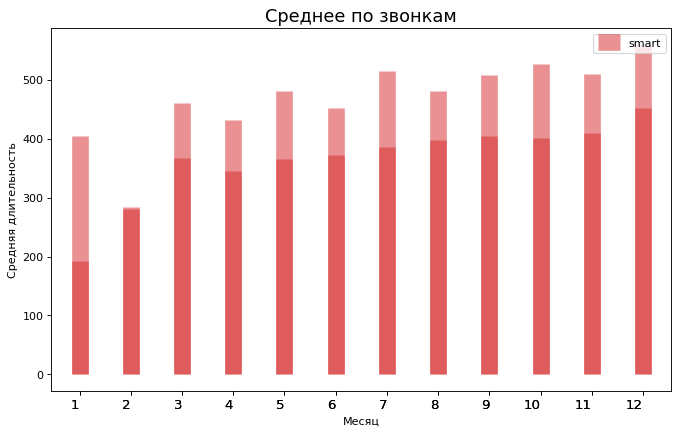

In [23]:
standart_hist(df_analyst_pvt.duration_mean, 
              'Среднее по звонкам', 'Месяц', 'Средняя длительность')

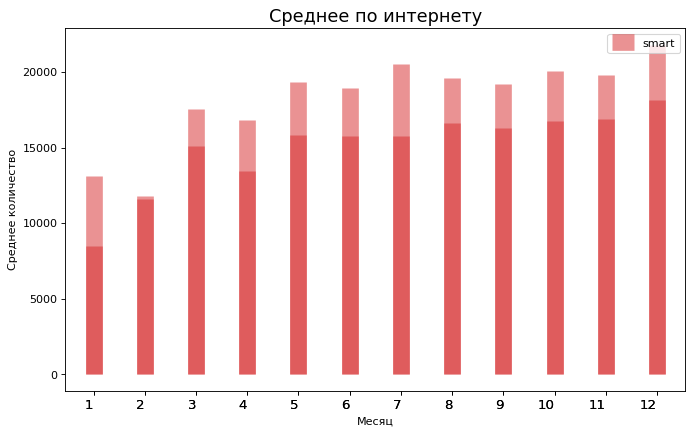

In [24]:
standart_hist(df_analyst_pvt.mb_used_mean,
              'Среднее по интернету', 'Месяц', 'Среднее количество')

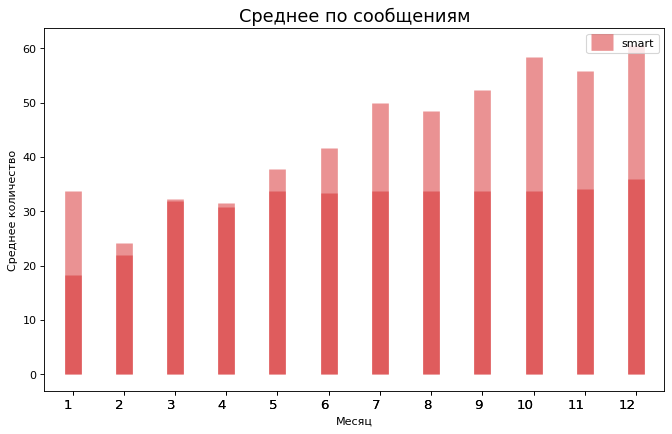

In [25]:
standart_hist(df_analyst_pvt.message_mean,
              'Среднее по сообщениям', 'Месяц', 'Среднее количество')

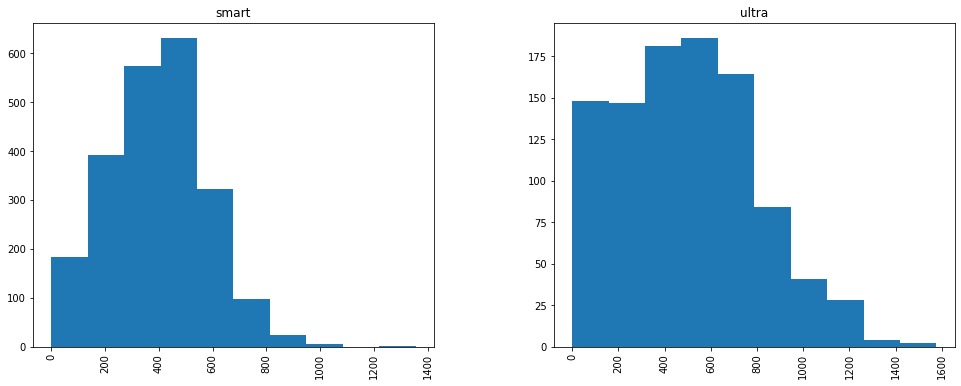

In [27]:
# Звонки

df_analyst.hist('duration_sum', 'tariff', figsize=(16,6))
plt.show()

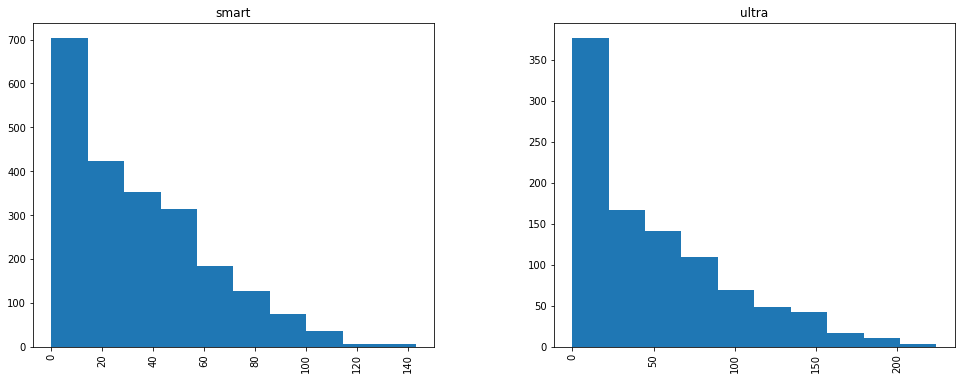

In [28]:
# Сообщения

df_analyst.hist('message_count', 'tariff', figsize=(16,6))
plt.show()

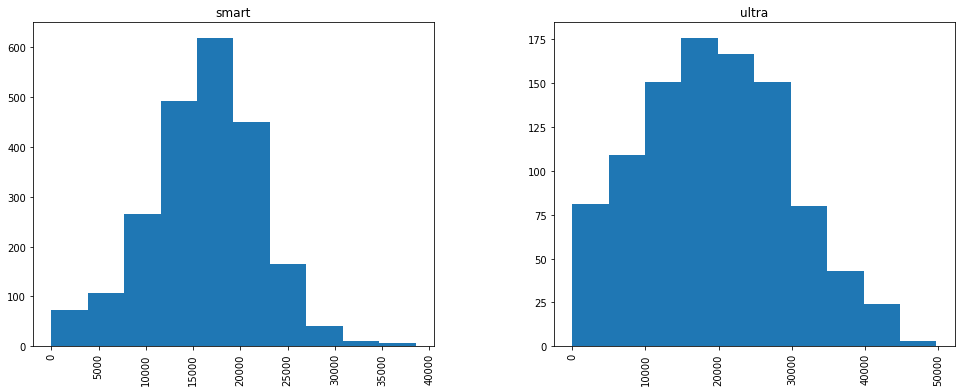

In [29]:
# Интернет

df_analyst.hist('mb_used_sum', 'tariff', figsize=(16,6))
plt.show()

In [30]:
# Для построения диаграммы выберу точки. Можно отслеживать интенсивность, когда много значений.

df_overpay = (df_earnings[df_earnings['rub_monthly_fee'] < df_earnings['earnings']]
              .sort_values('earnings', ascending=False))

df_overpay_u = df_overpay[df_overpay['tariff'] == 'ultra']
df_overpay_s = df_overpay[df_overpay['tariff'] == 'smart']

def construct_scatter(col, title, xlab, ylab):
    fig, ax = plt.subplots(1, 1, figsize=(16,10), dpi=80)

    plt.scatter(df_overpay_u.month+0.1, df_overpay_u[col], color='tab:red', label = 'ultra')
    plt.scatter(df_overpay_s.month-0.1, df_overpay_s[col], color='tab:blue', label = 'smart')
    ax.set_title(title, fontdict={'size':12})
    ax.set(xlabel=xlab, ylabel=ylab)
    plt.xticks(df_overpay_u.month, horizontalalignment='right', fontsize=12)
    plt.legend()
    plt.show()

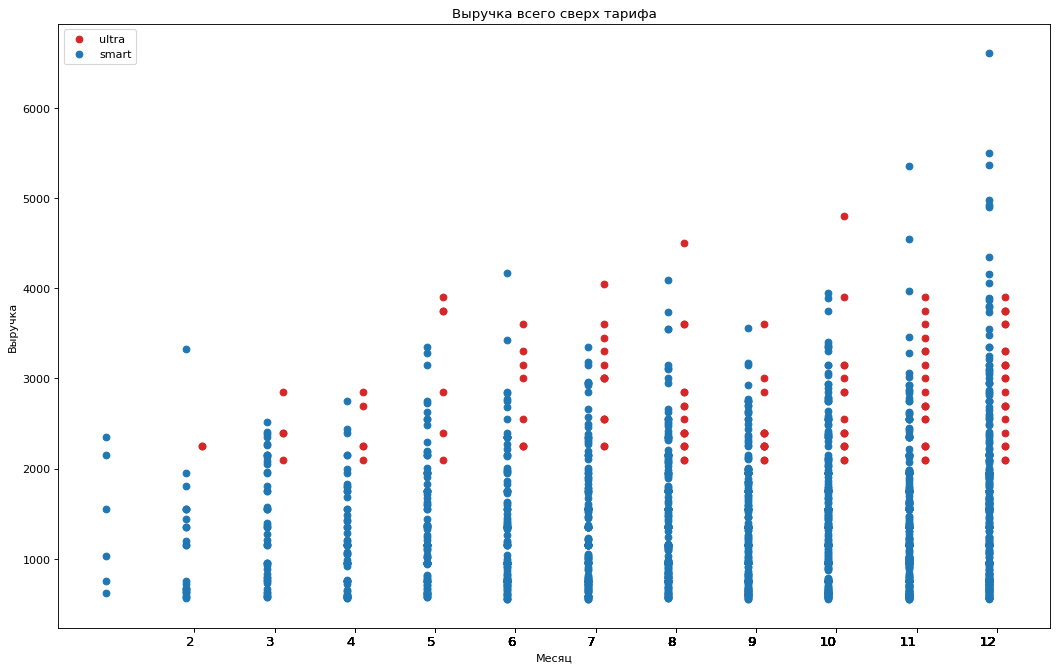

In [31]:
construct_scatter('earnings', 
                  'Выручка всего сверх тарифа', 
                  'Месяц', 
                  'Выручка')

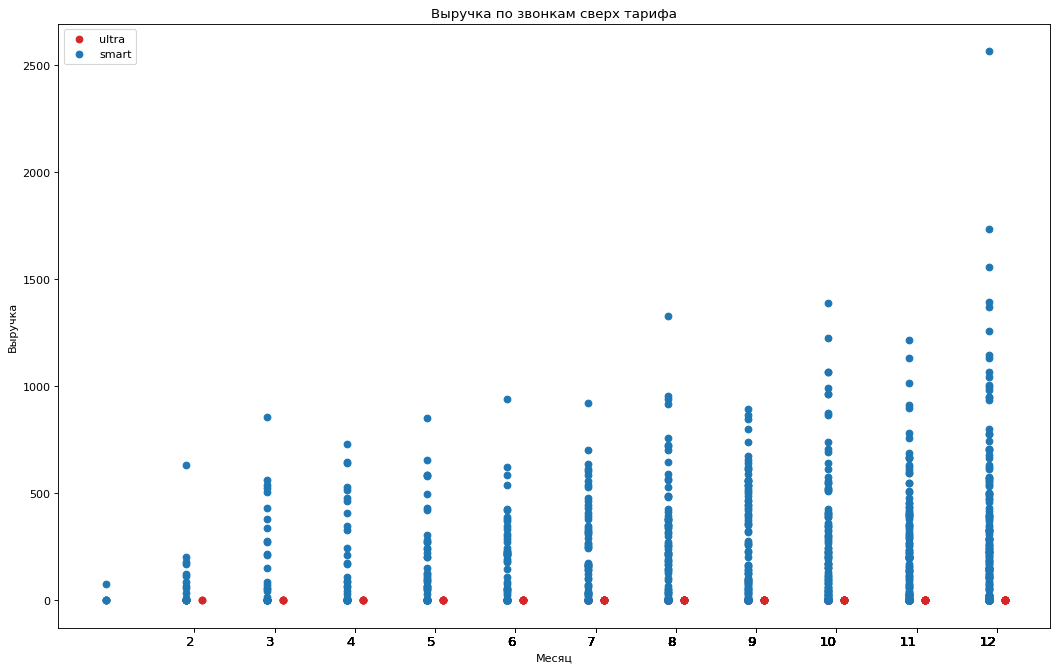

In [32]:
construct_scatter('call_earnings', 
                  'Выручка по звонкам сверх тарифа', 
                  'Месяц', 
                  'Выручка')

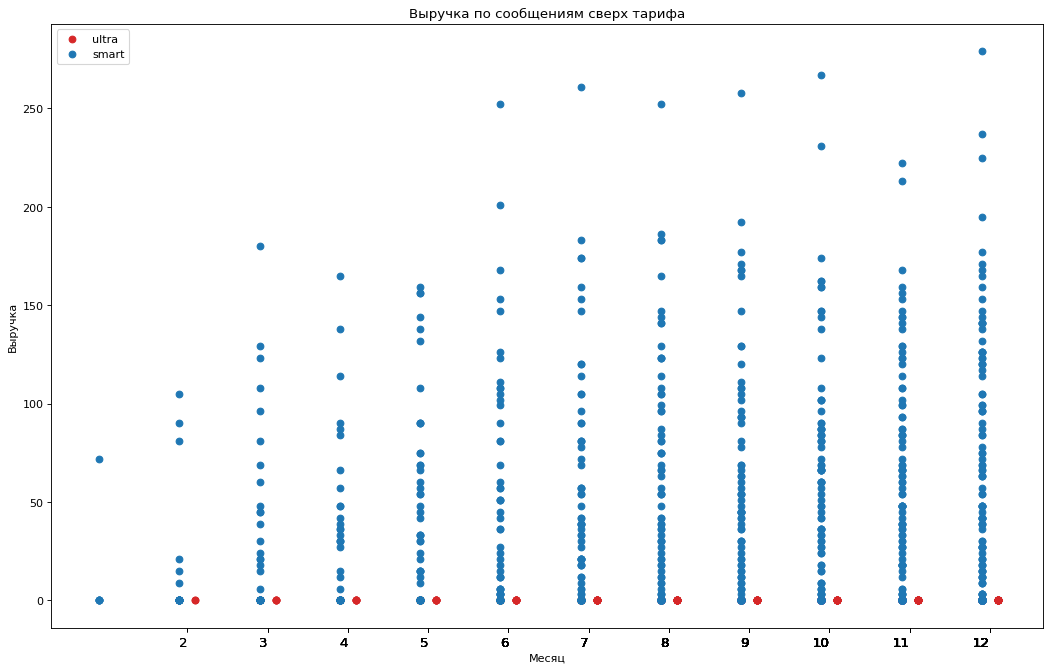

In [33]:
construct_scatter('msg_earnings', 
                  'Выручка по сообщениям сверх тарифа', 
                  'Месяц', 
                  'Выручка')

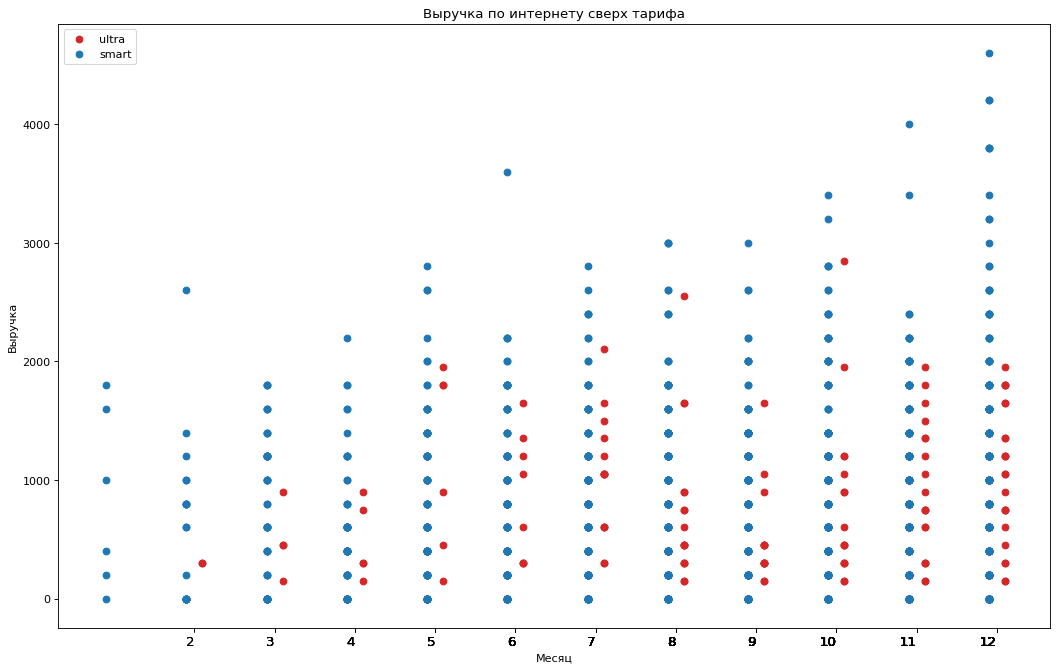

In [34]:
construct_scatter('int_earnings', 
                  'Выручка по интернету сверх тарифа', 
                  'Месяц', 
                  'Выручка')

In [35]:
# Найдём дисперсию.

df_analyst_pvt = (df_analyst
 .pivot_table(index=['tariff'], values=['duration_sum', 'message_count', 'mb_used_sum'], aggfunc = ['var'])
 .reset_index())

df_analyst_pvt.columns = ['tariff', 'duration_var', 'mb_used_var', 'message_var']
df_analyst_pvt

,tariff,duration_var,mb_used_var,message_var
0,smart,32361.127482,3.446227e+07,796.812958
1,ultra,89822.976563,1.017512e+08,2285.266143


In [36]:
# Найдём стандартное отклонение.

df_analyst_pvt = (df_analyst
 .pivot_table(index=['tariff'], values=['duration_sum', 'message_count', 'mb_used_sum'], aggfunc = ['std'])
 .reset_index())

df_analyst_pvt.columns = ['tariff', 'duration_std', 'mb_used_std' ,'message_std']
df_analyst_pvt

,tariff,duration_std,mb_used_std,message_std
0,smart,179.891988,5870.457630,28.227876
1,ultra,299.704816,10087.181432,47.804457


In [37]:
# Найдём среднее.

df_analyst_pvt = (df_analyst
 .pivot_table(index=['tariff'], values=['duration_sum', 'message_count', 'mb_used_sum'], aggfunc = ['mean'])
 .reset_index())

df_analyst_pvt.columns = ['tariff', 'duration_mean', 'mb_used_mean', 'message_mean']
df_analyst_pvt

,tariff,duration_mean,mb_used_mean,message_mean
0,smart,394.26873,16208.425303,33.384029
1,ultra,496.88934,19468.824365,49.363452


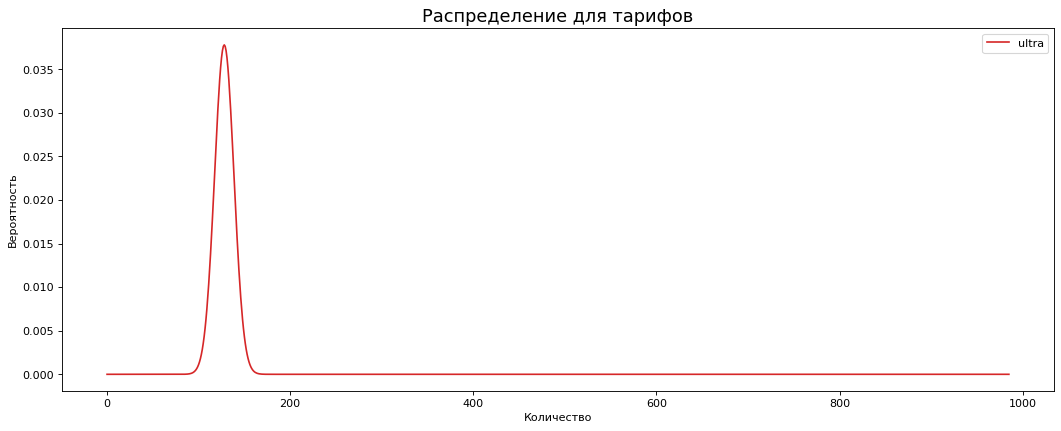

In [38]:
# Рисуем распределение.

import math as mt
from scipy.stats import norm


df_earnings_u = df_earnings[df_earnings['tariff'] == 'ultra']

fig, ax = plt.subplots(figsize=(16,6), dpi= 80)


n = df_earnings_u.earnings.count()
p = df_earnings_u[df_earnings_u['earnings']>df_earnings_u['rub_monthly_fee']].earnings.count()/df_earnings_u.earnings.count()


mu = n * p
var = n * p * (1-p)
sigma = mt.sqrt(var)

x = range(0, n+1)
norm_r = norm.pdf(x, mu, sigma)

plt.plot(range(0,n+1), norm_r[0:], color='tab:red', label = 'ultra')


ax.set_title('Распределение для тарифов', fontdict={'size':16})
ax.set(xlabel='Количество', ylabel='Вероятность')
plt.legend()
plt.show()

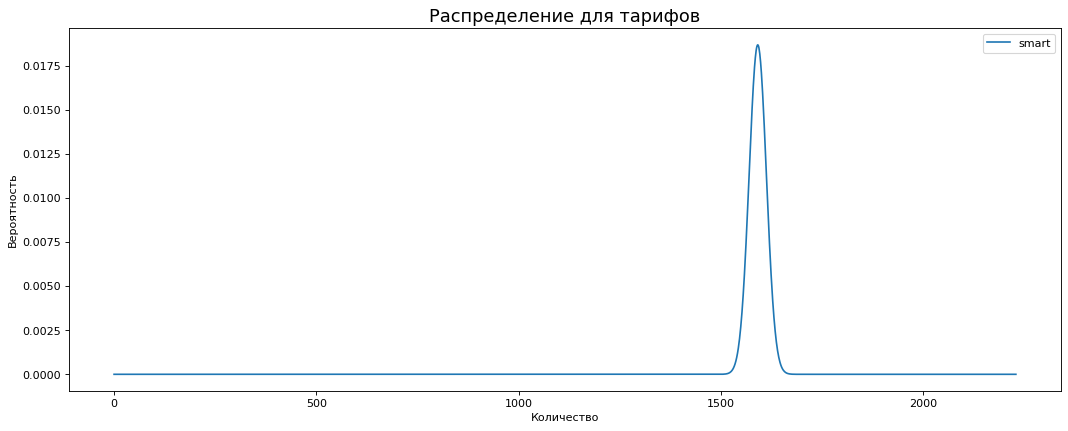

In [39]:
fig, ax = plt.subplots(figsize=(16,6), dpi= 80)


df_earnings_s = df_earnings[df_earnings['tariff'] == 'smart']

n = df_earnings_s.earnings.count()
p = df_earnings_s[df_earnings_s['earnings']>df_earnings_s['rub_monthly_fee']].earnings.count()/df_earnings_s.earnings.count()


mu = n * p
var = n * p * (1-p)
sigma = mt.sqrt(var)

x = range(0, n+1)
norm_r = norm.pdf(x, mu, sigma)

plt.plot(range(0,n+1), norm_r[0:], color='tab:blue', label = 'smart')


ax.set_title('Распределение для тарифов', fontdict={'size':16})
ax.set(xlabel='Количество', ylabel='Вероятность')
plt.legend()
plt.show()

### Вывод

По графикам среднего можно увидеть, что потребление звонков, интернета и сообщений максимально растёт от месяца к месяцу. Возможно, это сезонная динамика - спад в январе и рост до декабря из года в год.

По графикам потребления по услуге и тарифу можно увидеть, что больше потребляют пользователи с тарифом ultra.

По графикам выручки, можно увидеть, что многие пользователи тарифа smart превышают потребление определенное тарифом по всем услугам. По графику видим, что выручка от превышения тарифа smart часто превышает выручку от тарифа ultra. С другой стороны, пользователи тарифа ultra превышают только потребление интернета.

Стандартное отклонение показывает разброс реальных значений, можно заметить, что число больше других приходится на интернет.

Биноминальное распределение ultra скошено вправо, вероятность того, что пользователи будут превышать абонентскую плату - мала. И иначе выглядит распределение тарифа smart - скошено влево, это значит, что вероятность оплаты сверх тарифа велика. Использована апроксимация, так как n велико. 

## Шаг 4. Проверьте гипотезы

In [40]:
# Датасет для задачи.
df_hip = df_earnings[['city', 'tariff', 'earnings']]

In [41]:
"""
Формируем нулевую гипотезу:
средняя выручка пользователей тарифов Ультра и Смарт равны
Альтернативная:
средняя выручка пользователей тарифов Ультра и Смарт различается 
"""

from scipy import stats as st
   
alpha = .01 # критический уровень статистической значимости
    
results = st.ttest_ind(df_hip[df_hip['tariff'] == 'smart']['earnings'],
                       df_hip[df_hip['tariff'] == 'ultra']['earnings'])
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  7.973780789145512e-214
Отвергаем нулевую гипотезу


In [42]:
df_hip[df_hip['tariff'] == 'smart']['earnings'].mean()

1196.0399282189323

In [43]:
df_hip[df_hip['tariff'] == 'ultra']['earnings'].mean()

2059.492385786802

In [44]:
"""
Формируем нулевую гипотезу:
средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
Альтернативная:
средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
"""

alpha = .01 # критический уровень статистической значимости
    
results = st.ttest_ind(
    df_hip[df_hip['city'] == 'Москва']['earnings'],
    df_hip[df_hip['city'] != 'Москва']['earnings'])
    
print('p-значение: ', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4418818160370708
Не получилось отвергнуть нулевую гипотезу


### Вывод

Для задачи возьмем критерий Стьюдента, двустороннюю гипотезу. Нулевая гипотеза формулируется, как отсутствие различий.
Критерий значимости установим 0.01. Это значит, что смотрим на распределение справа и слева на 0,5% от предполагаемого значения.

Таким образом, средняя выручка пользователей тарифов Ультра и Смарт различается, а средняя выручка пользователей из Москвы примерно равна выручке пользователей из других регионов.

## Шаг 5. Напишите общий вывод

Получили 5 разных таблиц, 4 из которых были объеденены user_id. 

Провели предобработку даных, собрали их в такой вид, из которого уже можно получать информацию.

Проанализировали данные. Выявили, что потребление растёт от месяца к месяцу. Также увидели, что превышение звонков, сообщений и интернета чаще всего происходит у пользователей smart. 

Проверили гипотезы. Выявили, что средняя выручка на тарифе smart и ultra различается. Если смотреть по цифрам, то в 2 раза. Хоть большинство пользователей тарифа smart и превышают рамки абонентской платы, но всё же по средней выручке они не дотягивают до средней по тарифу ultra. Можно заключить, что пользователи тарифа ultra платят больше.

<b> Для оператора наиболее перспективно подключать пользователей на тариф ultra </b>
